In [ ]:
## Load required libraries and datasets
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import string
import re
import seaborn as sns
from sklearn import preprocessing
import scipy.stats 


#### Point the filePath
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Quantium/Task2/QVI_data.csv')

### Select control stores
The client has selected store numbers 77, 86 and 88 as trial stores and want control stores to be established stores that are operational for the entire observation period.
We would want to match trial stores to control stores that are similar to the trial
store prior to the trial period of Feb 2019 in terms of :
- Monthly overall sales revenue
- Monthly number of customers
- Monthly number of transactions per customer

We will create a measure to compare different control stores to each of the trial stores to do this write a function to reduce having to re-do the analysis for each trial store. Using Pearson correlations and a metric such as a magnitude distance e.g. 1- (Observed distance – minimum distance)/(Maximum distance – minimum distance) as a measure.

Once we selected control stores, compare each trial and control pair during the trial period. Then, test if total sales are significantly different in the trial period and if so, check if the driver of change is more purchasing customers or more purchases per customers etc.

Let's first create the metrics of interest and filter to stores that are present throughout the pre-trial period.

In [ ]:
#### Calculate these measures over time for each store
#### Add a new month ID column in the data with the format yyyymm.
data['YEARMONTH'] = pd.to_datetime(data['DATE']).dt.strftime('%Y%m').astype(int)

In [ ]:
#### Next, we define the measure calculations to use during the analysis.
group = data.groupby(['STORE_NBR','YEARMONTH'])
SALES = group.sum().TOT_SALES
NUM_CUST = group.nunique().LYLTY_CARD_NBR
TXN_PER_CUST = group.nunique().TXN_ID / group.nunique().LYLTY_CARD_NBR
AVG_Price = group.sum().TOT_SALES / group.sum().PROD_QTY
measures_over_time = pd.DataFrame({'TOT_SALES': SALES,'NUM_CUST':NUM_CUST, 'TXN_PER_CUST': TXN_PER_CUST,
                                  'AVG_PRICE':AVG_Price}).reset_index()
measures_over_time.head(20)

,STORE_NBR,YEARMONTH,TOT_SALES,NUM_CUST,TXN_PER_CUST,AVG_PRICE
0,1,201807,206.9,49,1.061224,3.337097
1,1,201808,176.1,42,1.023810,3.261111
2,1,201809,278.8,59,1.050847,3.717333
3,1,201810,188.1,44,1.022727,3.243103
4,1,201811,192.6,46,1.021739,3.378947
5,1,201812,189.6,42,1.119048,3.326316
6,1,201901,154.8,35,1.028571,3.685714
7,1,201902,225.4,52,1.057692,3.467692
8,1,201903,192.9,45,1.088889,3.325862
9,1,201904,192.9,42,1.023810,3.384211


In [ ]:
#### Filter to the pre-trial period and stores with full observation periods
measures_over_time_group_by = measures_over_time.groupby('STORE_NBR').count() # group by store
store_num = measures_over_time_group_by[measures_over_time_group_by.YEARMONTH == 12].index # get index of stores have full obs
stores_Full_Obs = measures_over_time.loc[measures_over_time.STORE_NBR.isin(store_num.tolist()),:]

pretrail_measures = stores_Full_Obs[stores_Full_Obs.YEARMONTH < 201902] # get pre-trial
pretrail_measures.head()

,STORE_NBR,YEARMONTH,TOT_SALES,NUM_CUST,TXN_PER_CUST,AVG_PRICE
0,1,201807,206.9,49,1.061224,3.337097
1,1,201808,176.1,42,1.023810,3.261111
2,1,201809,278.8,59,1.050847,3.717333
3,1,201810,188.1,44,1.022727,3.243103
4,1,201811,192.6,46,1.021739,3.378947


Now we need to work out a way of ranking how similar each potential control store is to the trial store. We can calculate how correlated the performance of each store is to the trial store.
Let's write a function for this so that we don't have to calculate this for each trial store and control store pair.

In [ ]:
# Over to you! Create a function to calculate correlation for a measure, looping through each control store.
def calculate_correlation (input_df, columns_name, store_compare):
  result = pd.DataFrame(columns=['store_1','store_2','correlation_measure'])
  stores = input_df.STORE_NBR.unique().tolist()

  for store in stores:
    store_1 =  input_df[input_df.STORE_NBR == store][columns_name].reset_index(drop=True)
    store_2 =  input_df[input_df.STORE_NBR == store_compare][columns_name].reset_index(drop=True)
    new_row = {'store_1' : store,
                'store_2' : store_compare,
                'correlation_measure' : store_1.corr(store_2, method='pearson')}
    result = result.append(new_row, ignore_index=True)

  result['store_1'] = result['store_1'].astype(int)
  result['store_2'] = result['store_2'].astype(int)
  return result.set_index(['store_1', 'store_2'])

Apart from correlation, we can also calculate a standardised metric based on the
absolute difference between the trial store's performance and each control store's
performance.
Let's write a function for this.

In [ ]:
#### Create a function to calculate a standardised magnitude distance for a measure
#### looping through each control store
def magnitude_distance (input_df, columns_name, store_compare):
  result = pd.DataFrame(columns=['store_1','store_2', 'yearmonth','magnitude'])
  stores = input_df.STORE_NBR.unique().tolist()

  for store in stores:
    store_1 =  input_df[input_df.STORE_NBR == store][columns_name].reset_index(drop=True)
    store_2 =  input_df[input_df.STORE_NBR == store_compare][columns_name].reset_index(drop=True)
    distance = abs(store_1 - store_2)
    calculated_measure = pd.DataFrame({'store_1' : store,
                          'store_2' : store_compare,
                          'yearmonth' : input_df.loc[input_df['STORE_NBR'] == store, 'YEARMONTH'].reset_index(drop=True),
                          'magnitude' : distance })
    
    x = calculated_measure[['magnitude']]
    min_max_scaler = preprocessing.MinMaxScaler()
    calculated_measure['magnitude'] = 1 - min_max_scaler.fit_transform(x)

    result = pd.concat([result, calculated_measure], ignore_index = True)
  return result.groupby(['store_1', 'store_2']).mean()


### Store 77

Now let’s use the functions to find the control stores! We’ll select control stores based on how similar monthly total sales in dollar amounts and monthly number of customers are to the trial stores. So we will need to use our functions to get four scores, two for each of total sales and total customers.

In [ ]:
trial_store = 77
#### Use the functions for calculating correlation
corr_sale = calculate_correlation(pretrail_measures, 'TOT_SALES', trial_store)
corr_cust = calculate_correlation(pretrail_measures, 'NUM_CUST', trial_store)
#### Use the functions for calculating magnitude
magnitude_sale = magnitude_distance(pretrail_measures, 'TOT_SALES', trial_store)
magnitude_cust = magnitude_distance(pretrail_measures, 'NUM_CUST', trial_store)

We’ll need to combine the all the scores calculated using our function to create a composite score to rank on.
Let’s take a simple average of the correlation and magnitude scores for each driver. Note that if we consider it more important for the trend of the drivers to be similar, we can increase the weight of the correlation score (a simple average gives a weight of 0.5 to the corr_weight) or if we consider the absolute size of the drivers to be more important, we can lower the weight of the correlation score.

In [ ]:
#### Create a combined score composed of correlation and magnitude
weight = 0.5

score_sales = pd.concat([corr_sale, magnitude_sale], axis=1, join='inner')
score_custs = pd.concat([corr_cust, magnitude_cust], axis=1, join='inner')

score_sales['score_sales'] = score_sales['correlation_measure'] * weight + score_sales['magnitude'] * (1 - weight)
score_custs['score_cust'] = score_custs['correlation_measure'] * weight + score_custs['magnitude'] * (1 - weight)

#### Combine scores across the drivers
score_control = pd.DataFrame(data = {'score_cust' : score_custs['score_cust'], 'score_sales' : score_sales['score_sales']})
score_control['final_control_score'] = score_control['score_cust'] * 0.5 + score_control['score_sales'] * 0.5

The store with the highest score is then selected as the control store since it is most similar to the trial store.

In [ ]:
## Select control stores based on the highest matching store but not the store it-self.
control_store = score_control.sort_values('final_control_score', ascending=False).reset_index()['store_1'][1]
print('Control store: {}'.format(control_store))

Control store: 233


Now that we have found a control store, let’s check visually if the drivers are indeed similar in the period before the trial.
We’ll look at total sales first.

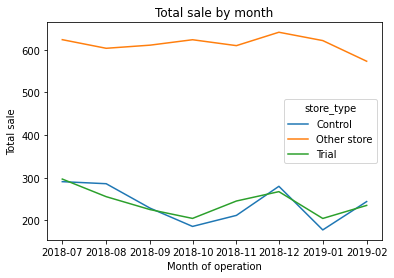

In [ ]:
def store_types(store_num):
  if store_num == trial_store:
    return "Trial"
  elif store_num == control_store:
    return "Control"
  else: 
    return "Other store"


#### Visual checks on trends based on the drivers

past_sales = measures_over_time.copy()
past_sales['store_type'] = past_sales.apply(lambda x: store_types(x['STORE_NBR']), axis=1)
past_sales['Transaction_month'] = pd.to_datetime((past_sales['YEARMONTH']*10+1).astype(str), format='%Y%m%d').loc[past_sales['YEARMONTH'] < 201903]
past_sales = past_sales.groupby(['store_type', 'Transaction_month']).mean().reset_index()
past_sales = past_sales.set_index('Transaction_month')


ax = sns.lineplot(data=past_sales, x='Transaction_month', y='TOT_SALES', hue='store_type')
ax.set(title='Total sale by month', ylabel='Total sale', xlabel='Month of operation')
plt.show()

Next, number of customers.

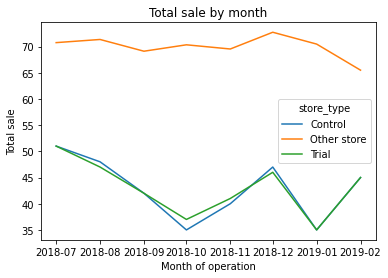

In [ ]:
ax = sns.lineplot(data=past_sales, x='Transaction_month', y='NUM_CUST', hue='store_type')
ax.set(title='Total sale by month', ylabel='Total sale', xlabel='Month of operation')
plt.show()

#### Assessment of trial
The trial period goes from the start of March 2019 to June 2019. We now want to see if there has been an uplift in overall chip sales.
We’ll start with scaling the control store’s sales to a level similar to control for any differences between the two stores outside of the trial period.

In [ ]:
#### Scale pre‐trial control sales to match pre‐trial trial store sales
scaling_factor = pretrail_measures[(pretrail_measures['YEARMONTH'] < 201902) & (pretrail_measures['STORE_NBR'] == trial_store)]['TOT_SALES'].sum() / pretrail_measures.loc[(pretrail_measures['YEARMONTH'] < 201902) & (pretrail_measures['STORE_NBR'] == control_store)]['TOT_SALES'].sum()
#### Apply the scaling factor
scaled_control_sales = measures_over_time.copy()
scaled_control_sales = scaled_control_sales.loc[measures_over_time['STORE_NBR'] == control_store]
scaled_control_sales['control_sales'] = scaled_control_sales['TOT_SALES'] * scaling_factor
scaled_control_sales

,STORE_NBR,YEARMONTH,TOT_SALES,NUM_CUST,TXN_PER_CUST,AVG_PRICE,control_sales
2699,233,201807,290.7,51,1.058824,3.303409,297.565550
2700,233,201808,285.9,48,1.041667,3.573750,292.652187
2701,233,201809,228.6,42,1.071429,3.265714,233.998916
2702,233,201810,185.7,35,1.028571,3.316071,190.085733
2703,233,201811,211.6,40,1.025000,3.412903,216.597421
2704,233,201812,279.8,47,1.063830,3.730667,286.408121
2705,233,201901,177.5,35,1.000000,3.776596,181.692071
2706,233,201902,244.0,45,1.044444,3.485714,249.762622
2707,233,201903,199.1,40,1.025000,3.374576,203.802205
2708,233,201904,158.6,30,1.066667,3.447826,162.345704


Now that we have comparable sales figures for the control store, we can calculate the percentage difference between the scaled control sales and the trial store’s sales during the trial period.

In [ ]:
#### Calculate the percentage difference between scaled control sales and trial  sales

left = scaled_control_sales[['YEARMONTH', 'control_sales']].set_index('YEARMONTH')
right = measures_over_time.loc[measures_over_time.STORE_NBR == trial_store][['TOT_SALES','YEARMONTH']].set_index('YEARMONTH')
percentage_diff = pd.concat([left, right], axis=1)
percentage_diff['percentage_diff'] = percentage_diff.apply(lambda x: abs(x['control_sales'] - x['TOT_SALES']) / x['control_sales'], axis=1)
percentage_diff

,control_sales,TOT_SALES,percentage_diff
YEARMONTH,,,
201807,297.565550,296.8,0.002573
201808,292.652187,255.5,0.126950
201809,233.998916,225.2,0.037602
201810,190.085733,204.5,0.075830
201811,216.597421,245.3,0.132516
201812,286.408121,267.3,0.066716
201901,181.692071,204.4,0.124980
201902,249.762622,235.0,0.059107
201903,203.802205,278.5,0.366521


Let’s see if the difference is significant!

In [ ]:
#### As our null hypothesis is that the trial period is the same as the
### pre‐trial period, let's take the standard deviation based on the scaled
### percentage difference in the pre‐trial period
std_dev = percentage_diff[percentage_diff.index < 201902]['percentage_diff'].std()

#### note that there are 8 months in the pre‐trial period #### hence 8 ‐ 1 = 7 degrees of freedom
degrees_off_freedom = 7

#### We will test with a null hypothesis of there being 0 difference between trial
#### and control stores

percentage_diff['t_value'] = (percentage_diff['percentage_diff'] - 0) / std_dev
percentage_diff['Transaction_month'] = pd.to_datetime((percentage_diff.index*10+1).astype(str), format='%Y%m%d')
percentage_diff.loc[(percentage_diff.index < 201905) & (percentage_diff.index > 201901)][['Transaction_month', 't_value']]

,Transaction_month,t_value
YEARMONTH,,
201902,2019-02-01,1.183534
201903,2019-03-01,7.339116
201904,2019-04-01,12.476373


In [ ]:
#### Find the 95th percentile of the t distribution with the appropriate #### degrees of freedom to compare against
scipy.stats.t.isf(0.95, 7) 

-1.894578605061305

We can observe that the t-value is much larger than the 95th percentile value of the t-distribution for March and April - i.e. the increase in sales in the trial store in March and April is statistically greater than in the control store.
Let’s create a more visual version of this by plotting the sales of the control store, the sales of the trial stores and the 95th percentile value of sales of the control store.

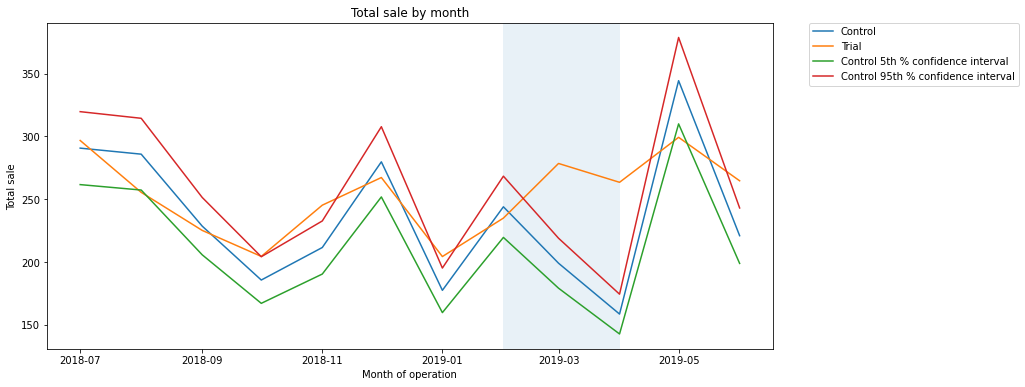

In [ ]:
past_sales = measures_over_time.copy()
past_sales['store_type'] = past_sales.apply(lambda x: store_types(x['STORE_NBR']), axis=1)
past_sales['Transaction_month'] = pd.to_datetime((past_sales['YEARMONTH']*10+1).astype(str), format='%Y%m%d')
past_sales = past_sales.groupby(['store_type', 'Transaction_month']).mean().reset_index()
past_sales = past_sales.loc[past_sales['store_type'].isin(['Control', 'Trial'])]
past_sales = past_sales.set_index('Transaction_month')

#### Control store 95th percentile
past_sales_controls95 = past_sales[past_sales['store_type'] == 'Control'].copy()
past_sales_controls95['TOT_SALES'] = past_sales_controls95['TOT_SALES'] * (1 + std_dev * 2)
past_sales_controls95['store_type'] = "Control 95th % confidence interval"


# #### Control store 5th percentile
past_sales_controls5 = past_sales[past_sales['store_type'] == 'Control'].copy()
past_sales_controls5['TOT_SALES'] = past_sales_controls5['TOT_SALES'] * (1 - std_dev * 2)
past_sales_controls5['store_type'] = "Control 5th % confidence interval"

trial_assessment = pd.concat([past_sales, past_sales_controls5, past_sales_controls95], axis = 0)

plt.figure(figsize=(13, 6))
plt.axvspan(pd.Timestamp('2019-04-01 00:00:00'), pd.Timestamp('2019-02-01 00:00:00'), alpha=0.1)
ax = sns.lineplot(data=trial_assessment, x='Transaction_month', y='TOT_SALES', hue='store_type')
ax.set(title='Total sale by month', ylabel='Total sale', xlabel='Month of operation')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

The results show that the trial in store 77 is significantly different to its control store in the trial period as the trial store performance lies outside the 5% to 95% confidence interval of the control store in two of the three trial months.
Let’s have a look at assessing this for number of customers as well.

In [ ]:
#### This would be a repeat of the steps before for total sales
#### Scale pre‐trial control customers to match pre‐trial trial store customers

scaling_factor = pretrail_measures[(pretrail_measures['YEARMONTH'] < 201902) & (pretrail_measures['STORE_NBR'] == trial_store)]['NUM_CUST'].sum() / pretrail_measures.loc[(pretrail_measures['YEARMONTH'] < 201902) & (pretrail_measures['STORE_NBR'] == control_store)]['NUM_CUST'].sum()
#### Apply the scaling factor
scaled_control = measures_over_time.copy()
scaled_control = scaled_control.loc[scaled_control['STORE_NBR'] == control_store]
scaled_control['control_cust'] = scaled_control['NUM_CUST'] * scaling_factor

left = scaled_control[['YEARMONTH', 'control_cust']].set_index('YEARMONTH')
right = measures_over_time.loc[measures_over_time.STORE_NBR == trial_store][['NUM_CUST','YEARMONTH']].set_index('YEARMONTH')
percentage_diff = pd.concat([left, right], axis=1)
percentage_diff['percentage_diff'] = percentage_diff.apply(lambda x: abs(x['control_cust'] - x['NUM_CUST']) / x['control_cust'], axis=1)

Let’s again see if the difference is significant visually!

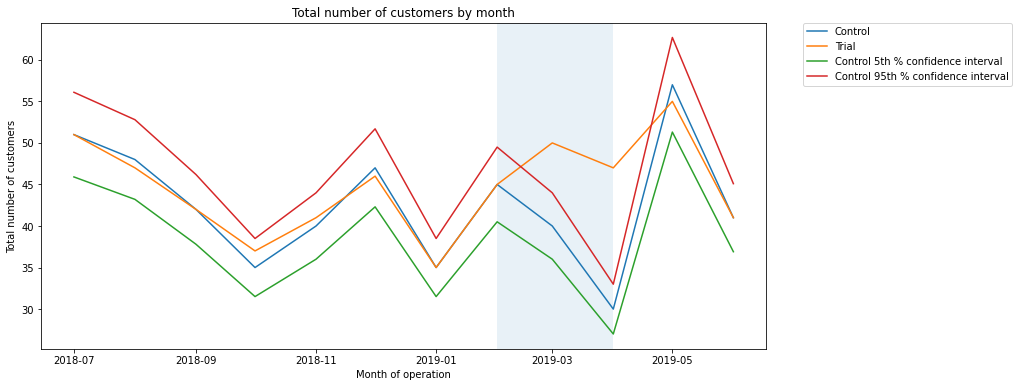

In [ ]:
past = measures_over_time.copy()
past['store_type'] = past.apply(lambda x: store_types(x['STORE_NBR']), axis=1)
past['Transaction_month'] = pd.to_datetime((past['YEARMONTH']*10+1).astype(str), format='%Y%m%d')
past = past.loc[past['store_type'].isin(['Control', 'Trial'])]
past = past.groupby(['store_type', 'Transaction_month']).mean().reset_index()

past = past.set_index('Transaction_month')

#### Control store 95th percentile
past_controls95 = past[past['store_type'] == 'Control'].copy()
past_controls95['NUM_CUST'] = past_controls95['NUM_CUST'] * (1 + std_dev * 2)
past_controls95['store_type'] = "Control 95th % confidence interval"


# #### Control store 5th percentile
past_controls5 = past[past['store_type'] == 'Control'].copy()
past_controls5['NUM_CUST'] = past_controls5['NUM_CUST'] * (1 - std_dev * 2)
past_controls5['store_type'] = "Control 5th % confidence interval"

trial_assessment = pd.concat([past, past_controls5, past_controls95], axis = 0)

plt.figure(figsize=(13, 6))
plt.axvspan(pd.Timestamp('2019-04-01 00:00:00'), pd.Timestamp('2019-02-01 00:00:00'), alpha=0.1)
ax = sns.lineplot(data=trial_assessment, x='Transaction_month', y='NUM_CUST', hue='store_type')
ax.set(title='Total number of customers by month', ylabel='Total number of customers', xlabel='Month of operation')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

Let’s repeat finding the control store and assessing the impact of the trial for each of the other two trial stores.*italicized text*

### Store 86

In [ ]:
trial_store = 86
#### Use the functions for calculating correlation
corr_sale = calculate_correlation(pretrail_measures, 'TOT_SALES', trial_store)
corr_cust = calculate_correlation(pretrail_measures, 'NUM_CUST', trial_store)
#### Use the functions for calculating magnitude
magnitude_sale = magnitude_distance(pretrail_measures, 'TOT_SALES', trial_store)
magnitude_cust = magnitude_distance(pretrail_measures, 'NUM_CUST', trial_store)

In [ ]:
#### Create a combined score composed of correlation and magnitude
weight = 0.5

score_sales = pd.concat([corr_sale, magnitude_sale], axis=1, join='inner')
score_custs = pd.concat([corr_cust, magnitude_cust], axis=1, join='inner')

score_sales['score_sales'] = score_sales['correlation_measure'] * weight + score_sales['magnitude'] * (1 - weight)
score_custs['score_cust'] = score_custs['correlation_measure'] * weight + score_custs['magnitude'] * (1 - weight)

#### Combine scores across the drivers
score_control = pd.DataFrame(data = {'score_cust' : score_custs['score_cust'], 'score_sales' : score_sales['score_sales']})
score_control['final_control_score'] = score_control['score_cust'] * 0.5 + score_control['score_sales'] * 0.5

In [ ]:
## Select control stores based on the highest matching store but not the store it-self.
control_store = score_control.sort_values('final_control_score', ascending=False).reset_index()['store_1'][1]
print('Control store: {}'.format(control_store))

Control store: 155


Looks like store 155 will be a control store for trial store 86. Again, let’s check visually if the drivers are indeed similar in the period before the trial.
We’ll look at total sales first.

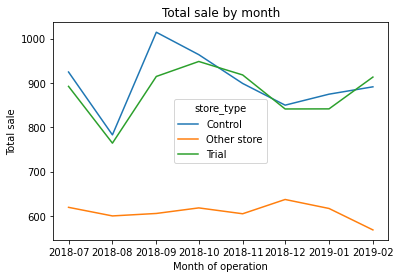

In [ ]:
def store_types(store_num):
  if store_num == trial_store:
    return "Trial"
  elif store_num == control_store:
    return "Control"
  else: 
    return "Other store"


#### Visual checks on trends based on the drivers

past_sales = measures_over_time.copy()
past_sales['store_type'] = past_sales.apply(lambda x: store_types(x['STORE_NBR']), axis=1)
past_sales['Transaction_month'] = pd.to_datetime((past_sales['YEARMONTH']*10+1).astype(str), format='%Y%m%d').loc[past_sales['YEARMONTH'] < 201903]
past_sales = past_sales.groupby(['store_type', 'Transaction_month']).mean().reset_index()
past_sales = past_sales.set_index('Transaction_month')


ax = sns.lineplot(data=past_sales, x='Transaction_month', y='TOT_SALES', hue='store_type')
ax.set(title='Total sale by month', ylabel='Total sale', xlabel='Month of operation')
plt.show()

Great, sales are trending in a similar way. Next, number of customers.

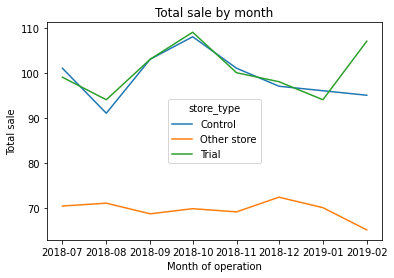

In [ ]:
ax = sns.lineplot(data=past_sales, x='Transaction_month', y='NUM_CUST', hue='store_type')
ax.set(title='Total sale by month', ylabel='Total sale', xlabel='Month of operation')
plt.show()

Good, the trend in number of customers is also similar. Let’s now assess the impact of the trial on sales.

In [ ]:
#### Scale pre‐trial control sales to match pre‐trial trial store sales
scaling_factor = pretrail_measures[(pretrail_measures['YEARMONTH'] < 201902) & (pretrail_measures['STORE_NBR'] == trial_store)]['TOT_SALES'].sum() / pretrail_measures.loc[(pretrail_measures['YEARMONTH'] < 201902) & (pretrail_measures['STORE_NBR'] == control_store)]['TOT_SALES'].sum()
#### Apply the scaling factor
scaled_control_sales = measures_over_time.copy()
scaled_control_sales = scaled_control_sales.loc[measures_over_time['STORE_NBR'] == control_store]
scaled_control_sales['control_sales'] = scaled_control_sales['TOT_SALES'] * scaling_factor

In [ ]:
#### Calculate the percentage difference between scaled control sales and trial  sales

left = scaled_control_sales[['YEARMONTH', 'control_sales']].set_index('YEARMONTH')
right = measures_over_time.loc[measures_over_time.STORE_NBR == trial_store][['TOT_SALES','YEARMONTH']].set_index('YEARMONTH')
percentage_diff = pd.concat([left, right], axis=1)
percentage_diff['percentage_diff'] = percentage_diff.apply(lambda x: abs(x['control_sales'] - x['TOT_SALES']) / x['control_sales'], axis=1)

In [ ]:
#### As our null hypothesis is that the trial period is the same as the
### pre‐trial period, let's take the standard deviation based on the scaled
### percentage difference in the pre‐trial period
std_dev = percentage_diff[percentage_diff.index < 201902]['percentage_diff'].std()

#### note that there are 8 months in the pre‐trial period #### hence 8 ‐ 1 = 7 degrees of freedom
degrees_off_freedom = 7

#### We will test with a null hypothesis of there being 0 difference between trial
#### and control stores

percentage_diff['t_value'] = (percentage_diff['percentage_diff'] - 0) / std_dev
percentage_diff['Transaction_month'] = pd.to_datetime((percentage_diff.index*10+1).astype(str), format='%Y%m%d')
percentage_diff.loc[(percentage_diff.index < 201905) & (percentage_diff.index > 201901)][['Transaction_month', 't_value']]

,Transaction_month,t_value
YEARMONTH,,
201902,2019-02-01,2.179542
201903,2019-03-01,12.226922
201904,2019-04-01,1.364580


In [ ]:
#### Find the 95th percentile of the t distribution with the appropriate #### degrees of freedom to compare against
scipy.stats.t.isf(0.95, 7) 

-1.894578605061305

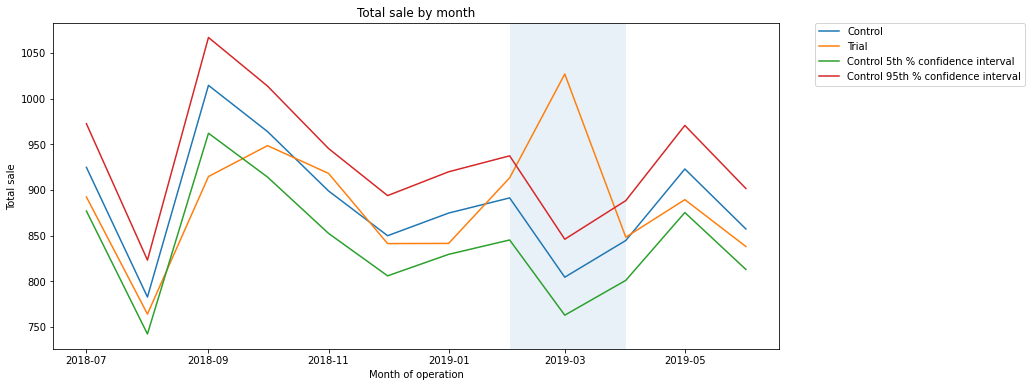

In [ ]:
past_sales = measures_over_time.copy()
past_sales['store_type'] = past_sales.apply(lambda x: store_types(x['STORE_NBR']), axis=1)
past_sales['Transaction_month'] = pd.to_datetime((past_sales['YEARMONTH']*10+1).astype(str), format='%Y%m%d')
past_sales = past_sales.groupby(['store_type', 'Transaction_month']).mean().reset_index()
past_sales = past_sales.loc[past_sales['store_type'].isin(['Control', 'Trial'])]
past_sales = past_sales.set_index('Transaction_month')

#### Control store 95th percentile
past_sales_controls95 = past_sales[past_sales['store_type'] == 'Control'].copy()
past_sales_controls95['TOT_SALES'] = past_sales_controls95['TOT_SALES'] * (1 + std_dev * 2)
past_sales_controls95['store_type'] = "Control 95th % confidence interval"


# #### Control store 5th percentile
past_sales_controls5 = past_sales[past_sales['store_type'] == 'Control'].copy()
past_sales_controls5['TOT_SALES'] = past_sales_controls5['TOT_SALES'] * (1 - std_dev * 2)
past_sales_controls5['store_type'] = "Control 5th % confidence interval"

trial_assessment = pd.concat([past_sales, past_sales_controls5, past_sales_controls95], axis = 0)

plt.figure(figsize=(13, 6))
plt.axvspan(pd.Timestamp('2019-04-01 00:00:00'), pd.Timestamp('2019-02-01 00:00:00'), alpha=0.1)
ax = sns.lineplot(data=trial_assessment, x='Transaction_month', y='TOT_SALES', hue='store_type')
ax.set(title='Total sale by month', ylabel='Total sale', xlabel='Month of operation')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

The results show that the trial in store 86 is not significantly different to its control store in the trial period as the trial store performance lies inside the 5% to 95% confidence interval of the control store in two of the three trial months.
Let’s have a look at assessing this for number of customers as well.

In [ ]:
#### This would be a repeat of the steps before for total sales
#### Scale pre‐trial control customers to match pre‐trial trial store customers

scaling_factor = pretrail_measures[(pretrail_measures['YEARMONTH'] < 201902) & (pretrail_measures['STORE_NBR'] == trial_store)]['NUM_CUST'].sum() / pretrail_measures.loc[(pretrail_measures['YEARMONTH'] < 201902) & (pretrail_measures['STORE_NBR'] == control_store)]['NUM_CUST'].sum()
#### Apply the scaling factor
scaled_control = measures_over_time.copy()
scaled_control = scaled_control.loc[measures_over_time['STORE_NBR'] == control_store]
scaled_control['control_cust'] = scaled_control['NUM_CUST'] * scaling_factor

left = scaled_control[['YEARMONTH', 'control_cust']].set_index('YEARMONTH')
right = measures_over_time.loc[measures_over_time.STORE_NBR == trial_store][['NUM_CUST','YEARMONTH']].set_index('YEARMONTH')
percentage_diff = pd.concat([left, right], axis=1)
percentage_diff['percentage_diff'] = percentage_diff.apply(lambda x: abs(x['control_cust'] - x['NUM_CUST']) / x['control_cust'], axis=1)

std_dev = percentage_diff[percentage_diff.index < 201902]['percentage_diff'].std()
degrees_off_freedom = 7

percentage_diff['t_value'] = (percentage_diff['percentage_diff'] - 0) / std_dev
percentage_diff['Transaction_month'] = pd.to_datetime((percentage_diff.index*10+1).astype(str), format='%Y%m%d')
percentage_diff.loc[(percentage_diff.index < 201905) & (percentage_diff.index > 201901)][['Transaction_month', 't_value']]



,Transaction_month,t_value
YEARMONTH,,
201902,2019-02-01,11.819082
201903,2019-03-01,20.903430
201904,2019-04-01,5.670772


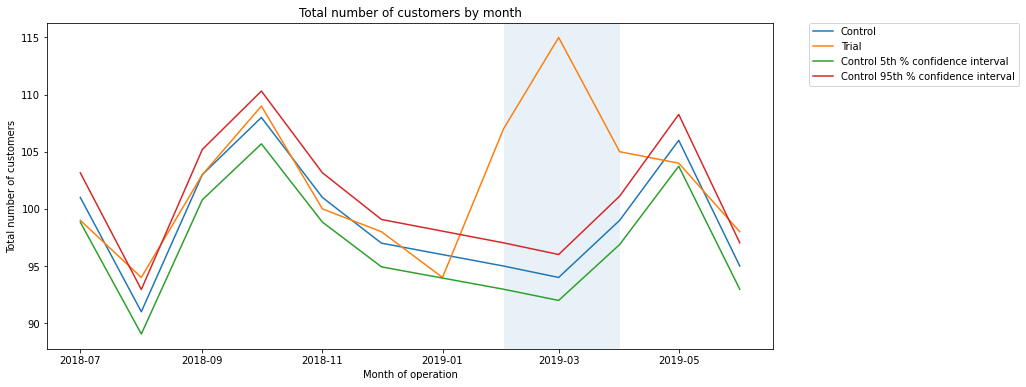

In [ ]:
past = measures_over_time.copy()
past['store_type'] = past.apply(lambda x: store_types(x['STORE_NBR']), axis=1)
past['Transaction_month'] = pd.to_datetime((past['YEARMONTH']*10+1).astype(str), format='%Y%m%d')
past = past.loc[past['store_type'].isin(['Control', 'Trial'])]
past = past.groupby(['store_type', 'Transaction_month']).mean().reset_index()

past = past.set_index('Transaction_month')

#### Control store 95th percentile
past_controls95 = past[past['store_type'] == 'Control'].copy()
past_controls95['NUM_CUST'] = past_controls95['NUM_CUST'] * (1 + std_dev * 2)
past_controls95['store_type'] = "Control 95th % confidence interval"


# #### Control store 5th percentile
past_controls5 = past[past['store_type'] == 'Control'].copy()
past_controls5['NUM_CUST'] = past_controls5['NUM_CUST'] * (1 - std_dev * 2)
past_controls5['store_type'] = "Control 5th % confidence interval"

trial_assessment = pd.concat([past, past_controls5, past_controls95], axis = 0)

plt.figure(figsize=(13, 6))
plt.axvspan(pd.Timestamp('2019-04-01 00:00:00'), pd.Timestamp('2019-02-01 00:00:00'), alpha=0.1)
ax = sns.lineplot(data=trial_assessment, x='Transaction_month', y='NUM_CUST', hue='store_type')
ax.set(title='Total number of customers by month', ylabel='Total number of customers', xlabel='Month of operation')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

It looks like the number of customers is significantly higher in all of the three months. This seems to suggest that the trial had a significant impact on increasing the number of customers in trial store 86 but as we saw, sales were not significantly higher. We should check with the Category Manager if there were special deals in the trial store that were may have resulted in lower prices, impacting the results.

### Store 88

In [ ]:
trial_store = 88
#### Use the functions for calculating correlation
corr_sale = calculate_correlation(pretrail_measures, 'TOT_SALES', trial_store)
corr_cust = calculate_correlation(pretrail_measures, 'NUM_CUST', trial_store)
#### Use the functions for calculating magnitude
magnitude_sale = magnitude_distance(pretrail_measures, 'TOT_SALES', trial_store)
magnitude_cust = magnitude_distance(pretrail_measures, 'NUM_CUST', trial_store)

In [ ]:
#### Create a combined score composed of correlation and magnitude
weight = 0.5

score_sales = pd.concat([corr_sale, magnitude_sale], axis=1, join='inner')
score_custs = pd.concat([corr_cust, magnitude_cust], axis=1, join='inner')

score_sales['score_sales'] = score_sales['correlation_measure'] * weight + score_sales['magnitude'] * (1 - weight)
score_custs['score_cust'] = score_custs['correlation_measure'] * weight + score_custs['magnitude'] * (1 - weight)

#### Combine scores across the drivers
score_control = pd.DataFrame(data = {'score_cust' : score_custs['score_cust'], 'score_sales' : score_sales['score_sales']})
score_control['final_control_score'] = score_control['score_cust'] * 0.5 + score_control['score_sales'] * 0.5

In [ ]:
## Select control stores based on the highest matching store but not the store it-self.
score_control = score_control.sort_values('final_control_score', ascending=False).reset_index()
control_store = score_control['store_1'][4]
print('Control store: {}'.format(control_store))

Control store: 237


We’ve now found store 237 to be a suitable control store for trial store 88.
Again, let’s check visually if the drivers are indeed similar in the period before the trial. We’ll look at total sales first.

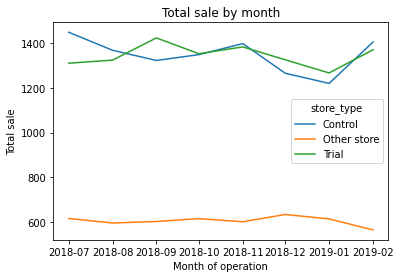

In [ ]:
def store_types(store_num):
  if store_num == trial_store:
    return "Trial"
  elif store_num == control_store:
    return "Control"
  else: 
    return "Other store"


#### Visual checks on trends based on the drivers

past_sales = measures_over_time.copy()
past_sales['store_type'] = past_sales.apply(lambda x: store_types(x['STORE_NBR']), axis=1)
past_sales['Transaction_month'] = pd.to_datetime((past_sales['YEARMONTH']*10+1).astype(str), format='%Y%m%d').loc[past_sales['YEARMONTH'] < 201903]
past_sales = past_sales.groupby(['store_type', 'Transaction_month']).mean().reset_index()
past_sales = past_sales.set_index('Transaction_month')


ax = sns.lineplot(data=past_sales, x='Transaction_month', y='TOT_SALES', hue='store_type')
ax.set(title='Total sale by month', ylabel='Total sale', xlabel='Month of operation')
plt.show()

Great, the trial and control stores have similar total sales. Next, number of customers.

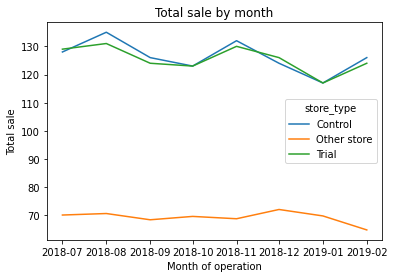

In [ ]:
ax = sns.lineplot(data=past_sales, x='Transaction_month', y='NUM_CUST', hue='store_type')
ax.set(title='Total sale by month', ylabel='Total sale', xlabel='Month of operation')
plt.show()

Total number of customers of the control and trial stores are also similar. Let’s now assess the impact of the trial on sales.

In [ ]:
#### Scale pre‐trial control sales to match pre‐trial trial store sales
scaling_factor = pretrail_measures[(pretrail_measures['YEARMONTH'] < 201902) & (pretrail_measures['STORE_NBR'] == trial_store)]['TOT_SALES'].sum() / pretrail_measures.loc[(pretrail_measures['YEARMONTH'] < 201902) & (pretrail_measures['STORE_NBR'] == control_store)]['TOT_SALES'].sum()
#### Apply the scaling factor
scaled_control_sales = measures_over_time.copy()
scaled_control_sales = scaled_control_sales.loc[measures_over_time['STORE_NBR'] == control_store]
scaled_control_sales['control_sales'] = scaled_control_sales['TOT_SALES'] * scaling_factor

In [ ]:
#### Calculate the percentage difference between scaled control sales and trial  sales

left = scaled_control_sales[['YEARMONTH', 'control_sales']].set_index('YEARMONTH')
right = measures_over_time.loc[measures_over_time.STORE_NBR == trial_store][['TOT_SALES','YEARMONTH']].set_index('YEARMONTH')
percentage_diff = pd.concat([left, right], axis=1)
percentage_diff['percentage_diff'] = percentage_diff.apply(lambda x: abs(x['control_sales'] - x['TOT_SALES']) / x['control_sales'], axis=1)

In [ ]:
#### As our null hypothesis is that the trial period is the same as the
### pre‐trial period, let's take the standard deviation based on the scaled
### percentage difference in the pre‐trial period
std_dev = percentage_diff[percentage_diff.index < 201902]['percentage_diff'].std()

#### note that there are 8 months in the pre‐trial period #### hence 8 ‐ 1 = 7 degrees of freedom
degrees_off_freedom = 7

#### We will test with a null hypothesis of there being 0 difference between trial
#### and control stores

percentage_diff['t_value'] = (percentage_diff['percentage_diff'] - 0) / std_dev
percentage_diff['Transaction_month'] = pd.to_datetime((percentage_diff.index*10+1).astype(str), format='%Y%m%d')
percentage_diff.loc[(percentage_diff.index < 201905) & (percentage_diff.index > 201901)][['Transaction_month', 't_value']]

,Transaction_month,t_value
YEARMONTH,,
201902,2019-02-01,0.781270
201903,2019-03-01,6.595668
201904,2019-04-01,5.768527


In [ ]:
#### Find the 95th percentile of the t distribution with the appropriate #### degrees of freedom to compare against
scipy.stats.t.isf(0.95, 7) 

-1.894578605061305

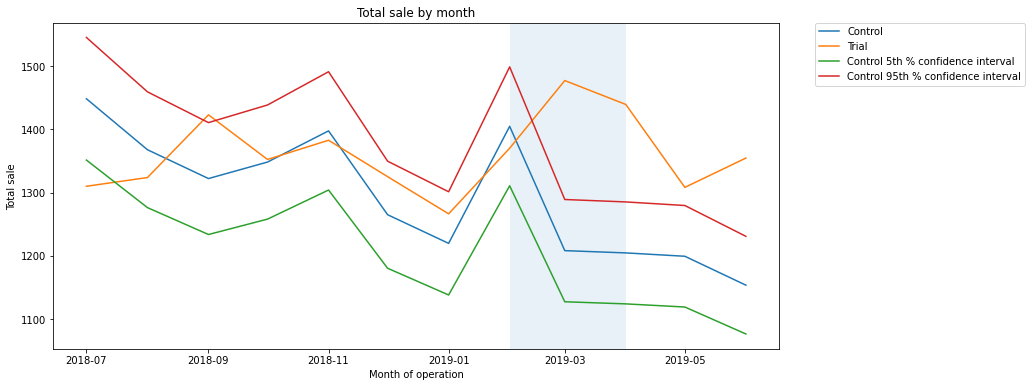

In [ ]:
past_sales = measures_over_time.copy()
past_sales['store_type'] = past_sales.apply(lambda x: store_types(x['STORE_NBR']), axis=1)
past_sales['Transaction_month'] = pd.to_datetime((past_sales['YEARMONTH']*10+1).astype(str), format='%Y%m%d')
past_sales = past_sales.groupby(['store_type', 'Transaction_month']).mean().reset_index()
past_sales = past_sales.loc[past_sales['store_type'].isin(['Control', 'Trial'])]
past_sales = past_sales.set_index('Transaction_month')

#### Control store 95th percentile
past_sales_controls95 = past_sales[past_sales['store_type'] == 'Control'].copy()
past_sales_controls95['TOT_SALES'] = past_sales_controls95['TOT_SALES'] * (1 + std_dev * 2)
past_sales_controls95['store_type'] = "Control 95th % confidence interval"


# #### Control store 5th percentile
past_sales_controls5 = past_sales[past_sales['store_type'] == 'Control'].copy()
past_sales_controls5['TOT_SALES'] = past_sales_controls5['TOT_SALES'] * (1 - std_dev * 2)
past_sales_controls5['store_type'] = "Control 5th % confidence interval"

trial_assessment = pd.concat([past_sales, past_sales_controls5, past_sales_controls95], axis = 0)

plt.figure(figsize=(13, 6))
plt.axvspan(pd.Timestamp('2019-04-01 00:00:00'), pd.Timestamp('2019-02-01 00:00:00'), alpha=0.1)
ax = sns.lineplot(data=trial_assessment, x='Transaction_month', y='TOT_SALES', hue='store_type')
ax.set(title='Total sale by month', ylabel='Total sale', xlabel='Month of operation')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

The results show that the trial in store 88 is significantly different to its control store in the trial period as the trial store performance lies outside of the 5% to 95% confidence interval of the control store in two of the three trial months.
Let’s have a look at assessing this for number of customers as well.

In [ ]:
#### This would be a repeat of the steps before for total sales
#### Scale pre‐trial control customers to match pre‐trial trial store customers

scaling_factor = pretrail_measures[(pretrail_measures['YEARMONTH'] < 201902) & (pretrail_measures['STORE_NBR'] == trial_store)]['NUM_CUST'].sum() / pretrail_measures.loc[(pretrail_measures['YEARMONTH'] < 201902) & (pretrail_measures['STORE_NBR'] == control_store)]['NUM_CUST'].sum()
#### Apply the scaling factor
scaled_control = measures_over_time.copy()
scaled_control = scaled_control.loc[measures_over_time['STORE_NBR'] == control_store]
scaled_control['control_cust'] = scaled_control['NUM_CUST'] * scaling_factor

left = scaled_control[['YEARMONTH', 'control_cust']].set_index('YEARMONTH')
right = measures_over_time.loc[measures_over_time.STORE_NBR == trial_store][['NUM_CUST','YEARMONTH']].set_index('YEARMONTH')
percentage_diff = pd.concat([left, right], axis=1)
percentage_diff['percentage_diff'] = percentage_diff.apply(lambda x: abs(x['control_cust'] - x['NUM_CUST']) / x['control_cust'], axis=1)

std_dev = percentage_diff[percentage_diff.index < 201902]['percentage_diff'].std()
degrees_off_freedom = 7

percentage_diff['t_value'] = (percentage_diff['percentage_diff'] - 0) / std_dev
percentage_diff['Transaction_month'] = pd.to_datetime((percentage_diff.index*10+1).astype(str), format='%Y%m%d')
percentage_diff.loc[(percentage_diff.index < 201905) & (percentage_diff.index > 201901)][['Transaction_month', 't_value']]



,Transaction_month,t_value
YEARMONTH,,
201902,2019-02-01,1.387456
201903,2019-03-01,17.873693
201904,2019-04-01,9.814423


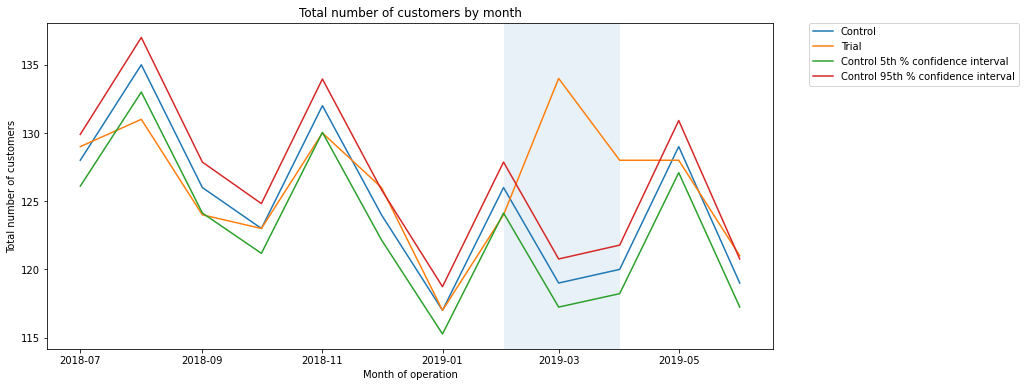

In [ ]:
past = measures_over_time.copy()
past['store_type'] = past.apply(lambda x: store_types(x['STORE_NBR']), axis=1)
past['Transaction_month'] = pd.to_datetime((past['YEARMONTH']*10+1).astype(str), format='%Y%m%d')
past = past.loc[past['store_type'].isin(['Control', 'Trial'])]
past = past.groupby(['store_type', 'Transaction_month']).mean().reset_index()

past = past.set_index('Transaction_month')

#### Control store 95th percentile
past_controls95 = past[past['store_type'] == 'Control'].copy()
past_controls95['NUM_CUST'] = past_controls95['NUM_CUST'] * (1 + std_dev * 2)
past_controls95['store_type'] = "Control 95th % confidence interval"


# #### Control store 5th percentile
past_controls5 = past[past['store_type'] == 'Control'].copy()
past_controls5['NUM_CUST'] = past_controls5['NUM_CUST'] * (1 - std_dev * 2)
past_controls5['store_type'] = "Control 5th % confidence interval"

trial_assessment = pd.concat([past, past_controls5, past_controls95], axis = 0)

plt.figure(figsize=(13, 6))
plt.axvspan(pd.Timestamp('2019-04-01 00:00:00'), pd.Timestamp('2019-02-01 00:00:00'), alpha=0.1)
ax = sns.lineplot(data=trial_assessment, x='Transaction_month', y='NUM_CUST', hue='store_type')
ax.set(title='Total number of customers by month', ylabel='Total number of customers', xlabel='Month of operation')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

Total number of customers in the trial period for the trial store is significantly higher than the control store for two out of three months, which indicates a positive trial effect.

### Conclusion
We’ve found control stores 233, 155, 237 for trial stores 77, 86 and 88 respectively.
The results for trial stores 77 and 88 during the trial period show a significant difference in at least two of the three trial months but this is not the case for trial store 86. We can check with the client if the implementation of the trial was different in trial store 86 but overall, the trial shows a significant increase in sales. Now that we have finished our analysis, we can prepare our presentation to the Category Manager.